In [56]:
from functools import lru_cache
from typing import Iterable, Any

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import transformers
import datasets
import torch

SEED = 42 
torch.manual_seed(SEED);

In [2]:
ds = datasets.load_dataset('deepmind/code_contests')
ds

Resolving data files:   0%|          | 0/39 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['name', 'description', 'public_tests', 'private_tests', 'generated_tests', 'source', 'difficulty', 'solutions', 'incorrect_solutions', 'cf_contest_id', 'cf_index', 'cf_points', 'cf_rating', 'cf_tags', 'is_description_translated', 'untranslated_description', 'time_limit', 'memory_limit_bytes', 'input_file', 'output_file'],
        num_rows: 13328
    })
    test: Dataset({
        features: ['name', 'description', 'public_tests', 'private_tests', 'generated_tests', 'source', 'difficulty', 'solutions', 'incorrect_solutions', 'cf_contest_id', 'cf_index', 'cf_points', 'cf_rating', 'cf_tags', 'is_description_translated', 'untranslated_description', 'time_limit', 'memory_limit_bytes', 'input_file', 'output_file'],
        num_rows: 165
    })
    valid: Dataset({
        features: ['name', 'description', 'public_tests', 'private_tests', 'generated_tests', 'source', 'difficulty', 'solutions', 'incorrect_solutions', 'cf_contest_id', 'cf_ind

In [3]:
# Get model for get_embeddings
model = transformers.AutoModel.from_pretrained('microsoft/codebert-base')
tokenizer = transformers.AutoTokenizer.from_pretrained('microsoft/codebert-base')

In [4]:
solutions = []
for sols, descriptions in zip(ds['test'].to_pandas()['solutions'], ds['test'].to_pandas()['description']):
  for lang_code, solution in zip(sols['language'], sols['solution']):
    solutions.append({'language_code': lang_code, 'solution': solution, 'description': descriptions})
solutions = pd.DataFrame(solutions)
solutions['len'] = solutions['solution'].str.len()
solutions

,language_code,solution,description,len
0,2,#include <bits/stdc++.h>\nusing namespace std;...,Andi and Budi were given an assignment to tidy...,1083
1,2,#include <bits/stdc++.h>\nusing namespace std;...,Andi and Budi were given an assignment to tidy...,686
2,2,#include <bits/stdc++.h>\nusing namespace std;...,Andi and Budi were given an assignment to tidy...,710
3,2,#include <bits/stdc++.h>\nusing namespace std;...,Andi and Budi were given an assignment to tidy...,755
4,2,#include <bits/stdc++.h>\nusing namespace std;...,Andi and Budi were given an assignment to tidy...,690
...,...,...,...,...
32176,2,#include <bits/stdc++.h>\n#pragma GCC optimize...,A binary tree of n nodes is given. Nodes of th...,1460
32177,2,#include <bits/stdc++.h>\nusing namespace std;...,A binary tree of n nodes is given. Nodes of th...,1070
32178,2,#include <bits/stdc++.h>\nusing namespace std;...,A binary tree of n nodes is given. Nodes of th...,1190
32179,2,#include <bits/stdc++.h>\nusing namespace std;...,A binary tree of n nodes is given. Nodes of th...,1348


<Axes: >

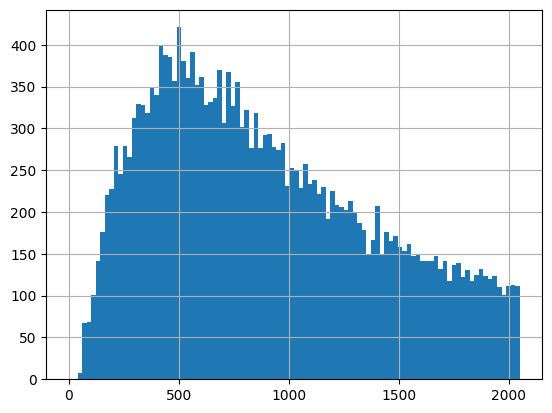

In [5]:
solutions['len'].hist(bins=100, range=(0, 2048))

In [69]:
import torch
from transformers import GPT2Tokenizer, GPT2Model

def embed(texts: [str], batch_size: int, model, tokenizer: transformers.PreTrainedTokenizerFast, max_len: int = 500) -> [torch.Tensor]:
  embeddings = []
  for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    encoded = tokenizer(batch, padding=True, return_tensors='pt')
    with torch.no_grad():
      outputs = model(input_ids=encoded.input_ids[:,:max_len], attention_mask=encoded.attention_mask[:,:max_len])
    embeddings.append(outputs.last_hidden_state[:,0,:])
  
  return torch.cat(embeddings)

In [6]:
embed_first_task = embed(texts=list(ds['test'].to_pandas()['solutions'].iloc[0]['solution']), batch_size=8, model=model, tokenizer=tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (1316 > 512). Running this sequence through the model will result in indexing errors


In [7]:
embed_first_task.shape

torch.Size([155, 768])

In [33]:
print(f"500 {sum(solutions['len'] < 500)/len(solutions)* 100:.1f}%")
print(f"1000 {sum(solutions['len'] < 1000)/len(solutions)*100:.1f}%")
print(f"2000 {sum(solutions['len'] < 2000)/len(solutions)*100:.1f}%")

500 17.9%
1000 42.5%
2000 68.1%


In [9]:
embed_second_task = embed(texts=list(ds['test'].to_pandas()['solutions'].iloc[1]['solution']), batch_size=8, model=model, tokenizer=tokenizer)

In [10]:
embed_second_task.shape

torch.Size([83, 768])

In [85]:
def get_random_pair(torch_tensor: torch.Tensor, torch_tensor2 : torch.Tensor | None = None) -> (torch.Tensor, torch.Tensor):
  """Returns a random pair of elements from a 2d torch tensor or from 2 tensors"""
  if torch_tensor2 is not None:
    return torch_tensor[torch.randint(0, torch_tensor.shape[0], (1,))], torch_tensor2[torch.randint(0, torch_tensor2.shape[0], (1,))]
  idx = torch.randint(0, torch_tensor.shape[0], (2,))
  return torch_tensor[idx[0]], torch_tensor[idx[1]]

def cos_difference(a: torch.Tensor, b: torch.Tensor) -> float:
  """Returns the cosine difference between two torch tensors"""
  if len(a.shape) == 1:
    return (1 - torch.nn.functional.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0))).item()
  return (1 - torch.nn.functional.cosine_similarity(a, b)).item()

def std_with_bootstrap(a: list, N=1000)-> float:
    """Returns the standard deviation of a list with bootstrap"""
    return np.std([np.mean(np.random.choice(a, size=len(a))) for _ in range(N)])

def mean_with_error(a: list, N=1000, pprint=False) -> (float, float):
    """Returns the mean and the error of a list with bootstrap"""
    if pprint:
      print(f"{np.mean(a):.4f} ± {std_with_bootstrap(a, N=N):.4f}")
    return np.mean(a), std_with_bootstrap(a, N=N)

def random_pair_iterator(x: Iterable, seed=SEED)-> Iterable:
  """Returns a generator of random pairs from an iterable"""
  np.random.seed(seed)
  while True:
    idx = np.random.randint(0, len(x), (2,))
    yield x[int(idx[0])], x[int(idx[1])]
      
def convert_dict(d):
    """ convert {'a': [1, 2, 3], 'b':[4, 5, 6]} to [{'a': 1, 'b':4}, ...]"""
    keys = list(d.keys())
    result = []
    for i in range(len(d[keys[0]])):
        item = {}
        for k in keys:
            item[k] = d[k][i]
        result.append(item)
    return result

def iter_dict(df: pd.DataFrame) -> Iterable:
    """Returns an iterable of a dataframe"""
    for i in range(len(df)):
        yield df.iloc[i].to_dict()

def limit(it: Iterable, limit: int):
    """Returns an iterable with a limit"""
    for i, el in enumerate(it):
        if i == limit:
          break
        yield el
        


[[1.0], [2.0], [3.0]]

In [74]:
mean_with_error([cos_difference(*get_random_pair(embed_first_task)) for _ in range(300)], pprint=True);

0.009 ± 0.001


In [75]:
mean_with_error([cos_difference(*get_random_pair(embed_first_task, embed_second_task)) for _ in range(300)], pprint=True);

0.013 ± 0.001


In [43]:
ds = ds.shuffle(seeds=SEED)
i = 0
data_same = []
data_diff = []
for el1, el2 in tqdm(random_pair_iterator(ds['test']), total=15):
    i += 1
    if i == 16:
      break
    # Get only python solutions
    sols1 = [*map(lambda x: x['solution'], filter(lambda x: x['language'] ==     2, convert_dict(el1['solutions'])))][:32]
    sols2 = [*map(lambda x: x['solution'], filter(lambda x: x['language'] == 2, convert_dict(el2['solutions'])))][:32]
    if not sols2 or not sols1:
      print('No python solutions', i)
      print(el1['solutions']['language'])
      continue
    embeddings_1 = embed(sols1, batch_size=16, model=model, tokenizer=tokenizer)
    embeddings_2 = embed(sols1, batch_size=16, model=model, tokenizer=tokenizer)
    
    data_diff+=[cos_difference(*get_random_pair(embeddings_1, embeddings_2)) for _ in range(32)]
    data_same+=[cos_difference(*get_random_pair(embeddings_1)) for _ in range(32)]

  0%|          | 0/15 [00:00<?, ?it/s]

In [53]:
print(sols2[1])

480


In [46]:
np.mean(data_same)/np.mean(data_diff)

1.0133668468004262

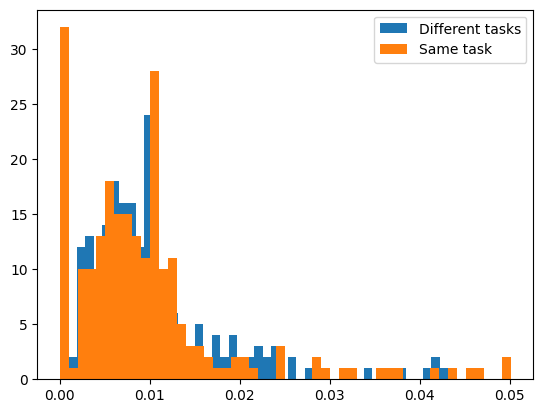

In [37]:
plt.hist(data_diff, bins=50)
plt.hist(data_same, bins=50)
plt.legend(['Different tasks', 'Same task'])

In [47]:
solutions

,language_code,solution,description,len
0,2,#include <bits/stdc++.h>\nusing namespace std;...,Andi and Budi were given an assignment to tidy...,1083
1,2,#include <bits/stdc++.h>\nusing namespace std;...,Andi and Budi were given an assignment to tidy...,686
2,2,#include <bits/stdc++.h>\nusing namespace std;...,Andi and Budi were given an assignment to tidy...,710
3,2,#include <bits/stdc++.h>\nusing namespace std;...,Andi and Budi were given an assignment to tidy...,755
4,2,#include <bits/stdc++.h>\nusing namespace std;...,Andi and Budi were given an assignment to tidy...,690
...,...,...,...,...
32176,2,#include <bits/stdc++.h>\n#pragma GCC optimize...,A binary tree of n nodes is given. Nodes of th...,1460
32177,2,#include <bits/stdc++.h>\nusing namespace std;...,A binary tree of n nodes is given. Nodes of th...,1070
32178,2,#include <bits/stdc++.h>\nusing namespace std;...,A binary tree of n nodes is given. Nodes of th...,1190
32179,2,#include <bits/stdc++.h>\nusing namespace std;...,A binary tree of n nodes is given. Nodes of th...,1348


In [55]:
solutions_python = solutions[solutions['language_code'] == 3]
solutions_cpp = solutions[solutions['language_code'] == 2]

diffs = []
for sol_py, sol_cpp in tqdm(limit(zip(solutions_python['solution'], solutions_cpp['solution']), 480), total=480):
    embs = embed([sol_py, sol_cpp], batch_size=2, model=model, tokenizer=tokenizer)
    diffs.append(cos_difference(embs[0], embs[1]))


0it [00:00, ?it/s]

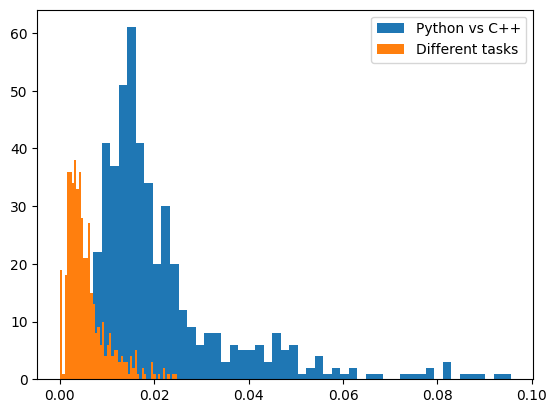

In [60]:
plt.hist(diffs, bins=50)
plt.hist(data_diff, bins=50)
plt.legend(['Python vs C++', 'Different tasks'])

In [73]:
solutions_python_short = solutions_python[solutions_python['len'] < 500]
solutions_python_short

,language_code,solution,description,len
8,3,from sys import stdin\n\ndef main():\n inpu...,Andi and Budi were given an assignment to tidy...,347
22,3,"l0 = [chr(x) for x in range(65, 91)]\nl1 = rev...",Andi and Budi were given an assignment to tidy...,310
34,3,"n, m = list(map(int, input().split()))\nl = []...",Andi and Budi were given an assignment to tidy...,226
63,3,\n\ndef to_tuple(s: str) -> tuple:\n return...,Andi and Budi were given an assignment to tidy...,293
78,3,"n , m = map(int, input().split())\nc = lambda ...",Andi and Budi were given an assignment to tidy...,284
...,...,...,...,...
31676,3,T=int(input())\nfor _ in range(T):\n N=int(in...,Alice and Bob play the following game. Alice h...,322
31677,3,def solve():\n n = int(input())\n ranges = s...,Alice and Bob play the following game. Alice h...,372
31775,3,"I=input\nfor _ in[0]*int(I()):\n\tn,h,s,b=int(...",There are n heaps of stone. The i-th heap has ...,236
31801,3,"import sys\nI=lambda:[*map(int, sys.stdin.read...",There are n heaps of stone. The i-th heap has ...,460


In [144]:
# Take only 16 elements
solutions_python_short_sample = solutions_python_short.sample(128)
solutions_python_short_sample

,language_code,solution,description,len
7792,3,\nfor _ in range(int(input())):\n n=int(inp...,You are given an array a of length n.\n\nLet's...,387
9020,3,#consecutivesumriddle\nT=int(input())\nwhile(T...,Theofanis has a riddle for you and if you mana...,117
13988,3,import math\nt = int(input())\n\ndef solve():\...,"Shohag has an integer sequence a_1, a_2, …, a_...",237
17115,3,"t = int(input())\nmaps = [\n lambda x: 0,\n...",The grasshopper is located on the numeric axis...,226
26589,3,def square_cube(n):\n sq = int(math.sqrt(n)...,Polycarp likes squares and cubes of positive i...,386
...,...,...,...,...
3866,3,"for _ in range(int(input())):n, m, k = map(int...",CQXYM wants to create a connected undirected g...,221
1137,3,# cook your dish here\nt = int(input())\nfor i...,Casimir has a string s which consists of capit...,389
9211,3,t = int(input())\nwhile t:\n arr = [int(a) ...,Theofanis really likes sequences of positive i...,282
24257,3,t = int(input())\nfor x in range(t):\n n = ...,Polycarp has come up with a new game to play w...,489


In [145]:
solutions_python_short_sample['embeddings_solution'] = list(embed(solutions_python_short_sample['solution'].tolist(), batch_size=4, model=model, tokenizer=tokenizer))

In [146]:
solutions_python_short_sample['embeddings_description'] = list(embed(solutions_python_short_sample['description'].tolist(), batch_size=4, model=model, tokenizer=tokenizer))

In [147]:
solutions_python_short_sample['embeddings_solution'] = solutions_python_short_sample['embeddings_solution'].apply(lambda l: [el.item() for el in l])
solutions_python_short_sample['embeddings_description'] = solutions_python_short_sample['embeddings_description'].apply(lambda l: [el.item() for el in l])

In [148]:
solutions_python_short_sample

,language_code,solution,description,len,embeddings_solution,embeddings_description
7792,3,\nfor _ in range(int(input())):\n n=int(inp...,You are given an array a of length n.\n\nLet's...,387,"[-0.20376896858215332, -0.16074980795383453, -...","[0.0628264993429184, 0.05430953949689865, -0.2..."
9020,3,#consecutivesumriddle\nT=int(input())\nwhile(T...,Theofanis has a riddle for you and if you mana...,117,"[-0.10832240432500839, -0.07871982455253601, -...","[0.10396896302700043, -0.022973448038101196, -..."
13988,3,import math\nt = int(input())\n\ndef solve():\...,"Shohag has an integer sequence a_1, a_2, …, a_...",237,"[-0.13185060024261475, -0.013844892382621765, ...","[0.017980627715587616, 0.05392761901021004, -0..."
17115,3,"t = int(input())\nmaps = [\n lambda x: 0,\n...",The grasshopper is located on the numeric axis...,226,"[-0.09435654431581497, -0.006350308656692505, ...","[0.0779174193739891, -0.07051628828048706, -0...."
26589,3,def square_cube(n):\n sq = int(math.sqrt(n)...,Polycarp likes squares and cubes of positive i...,386,"[-0.061300866305828094, -0.07839785516262054, ...","[0.1668926328420639, 0.08782201260328293, -0.1..."
...,...,...,...,...,...,...
3866,3,"for _ in range(int(input())):n, m, k = map(int...",CQXYM wants to create a connected undirected g...,221,"[-0.0015979334712028503, 0.001513645052909851,...","[0.020716436207294464, 0.1291285753250122, -0...."
1137,3,# cook your dish here\nt = int(input())\nfor i...,Casimir has a string s which consists of capit...,389,"[-0.33688053488731384, -0.017610229551792145, ...","[0.1040535718202591, 0.14531967043876648, -0.0..."
9211,3,t = int(input())\nwhile t:\n arr = [int(a) ...,Theofanis really likes sequences of positive i...,282,"[-0.12187131494283676, -0.01392614096403122, -...","[0.15568140149116516, 0.08171387016773224, -0...."
24257,3,t = int(input())\nfor x in range(t):\n n = ...,Polycarp has come up with a new game to play w...,489,"[-0.22801929712295532, -0.0740785151720047, -0...","[0.036405298858881, 0.10676584392786026, -0.13..."


In [149]:
# Use tsne to visualize the embeddings
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=SEED)

In [150]:
data2d = tsne.fit_transform(np.array(solutions_python_short_sample['embeddings_solution'].tolist() + solutions_python_short_sample['embeddings_description'].tolist()))

In [151]:
solutions_python_short_sample['tsne_solution'] = list(data2d[:len(solutions_python_short_sample)])
solutions_python_short_sample['tsne_description'] = list(data2d[len(solutions_python_short_sample):])

In [152]:
solutions_python_short_sample

,language_code,solution,description,len,embeddings_solution,embeddings_description,tsne_solution,tsne_description
7792,3,\nfor _ in range(int(input())):\n n=int(inp...,You are given an array a of length n.\n\nLet's...,387,"[-0.20376896858215332, -0.16074980795383453, -...","[0.0628264993429184, 0.05430953949689865, -0.2...","[171.18533, 36.003902]","[-132.20341, -68.7996]"
9020,3,#consecutivesumriddle\nT=int(input())\nwhile(T...,Theofanis has a riddle for you and if you mana...,117,"[-0.10832240432500839, -0.07871982455253601, -...","[0.10396896302700043, -0.022973448038101196, -...","[29.690151, -47.51985]","[-16.78484, 140.99425]"
13988,3,import math\nt = int(input())\n\ndef solve():\...,"Shohag has an integer sequence a_1, a_2, …, a_...",237,"[-0.13185060024261475, -0.013844892382621765, ...","[0.017980627715587616, 0.05392761901021004, -0...","[67.217155, -13.932869]","[-117.47239, -37.230556]"
17115,3,"t = int(input())\nmaps = [\n lambda x: 0,\n...",The grasshopper is located on the numeric axis...,226,"[-0.09435654431581497, -0.006350308656692505, ...","[0.0779174193739891, -0.07051628828048706, -0....","[73.45576, 6.923304]","[-151.08961, -10.146427]"
26589,3,def square_cube(n):\n sq = int(math.sqrt(n)...,Polycarp likes squares and cubes of positive i...,386,"[-0.061300866305828094, -0.07839785516262054, ...","[0.1668926328420639, 0.08782201260328293, -0.1...","[130.85994, 53.04511]","[-51.93575, 169.70549]"
...,...,...,...,...,...,...,...,...
3866,3,"for _ in range(int(input())):n, m, k = map(int...",CQXYM wants to create a connected undirected g...,221,"[-0.0015979334712028503, 0.001513645052909851,...","[0.020716436207294464, 0.1291285753250122, -0....","[139.27911, -134.23376]","[-50.65415, 130.15314]"
1137,3,# cook your dish here\nt = int(input())\nfor i...,Casimir has a string s which consists of capit...,389,"[-0.33688053488731384, -0.017610229551792145, ...","[0.1040535718202591, 0.14531967043876648, -0.0...","[174.80966, -7.093548]","[-101.82294, 85.65079]"
9211,3,t = int(input())\nwhile t:\n arr = [int(a) ...,Theofanis really likes sequences of positive i...,282,"[-0.12187131494283676, -0.01392614096403122, -...","[0.15568140149116516, 0.08171387016773224, -0....","[123.253586, -46.818]","[-53.046837, 146.8503]"
24257,3,t = int(input())\nfor x in range(t):\n n = ...,Polycarp has come up with a new game to play w...,489,"[-0.22801929712295532, -0.0740785151720047, -0...","[0.036405298858881, 0.10676584392786026, -0.13...","[148.18883, 44.897266]","[-72.12293, 23.610851]"


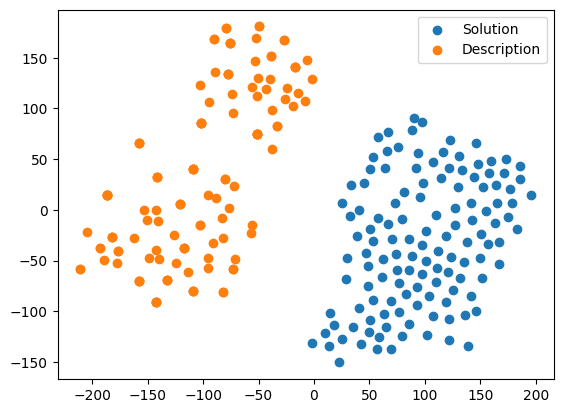

In [153]:
plt.scatter(solutions_python_short_sample['tsne_solution'].apply(lambda x: x[0]), solutions_python_short_sample['tsne_solution'].apply(lambda x: x[1]))
plt.scatter(solutions_python_short_sample['tsne_description'].apply(lambda x: x[0]), solutions_python_short_sample['tsne_description'].apply(lambda x: x[1]))

plt.legend(['Solution', 'Description'])

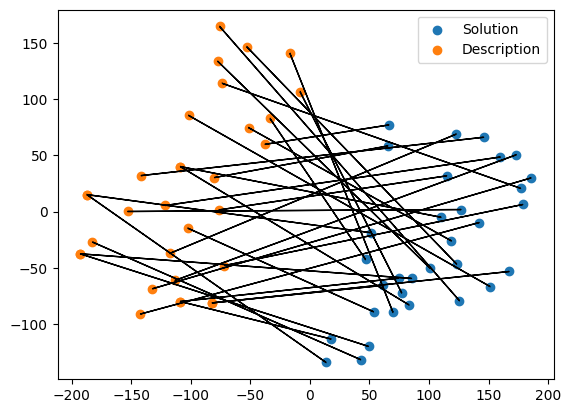

In [158]:
def plot_arrow(x1, y1, x2, y2):
  plt.arrow(x1, y1, x2-x1, y2-y1, head_width=0.005, head_length=0.01, fc='k', ec='k')

solutions_python_short_sample_arrows = solutions_python_short_sample.sample(32)

plt.scatter(solutions_python_short_sample_arrows['tsne_solution'].apply(lambda x: x[0]), solutions_python_short_sample_arrows['tsne_solution'].apply(lambda x: x[1]))
plt.scatter(solutions_python_short_sample_arrows['tsne_description'].apply(lambda x: x[0]), solutions_python_short_sample_arrows['tsne_description'].apply(lambda x: x[1]))

arrows = [plot_arrow(*sol_py, *sol_desc) for sol_py, sol_desc in zip(solutions_python_short_sample_arrows['tsne_solution'], solutions_python_short_sample_arrows['tsne_description'])]

plt.legend(['Solution', 'Description'])